# Thoth

In Bayesian analysis, priors are needed. Prior define the belief - defined as a probability function - about parameters before any analysis. For this model we require, for mathematical closure a prior for the initial activity 230Th to 232Th ratio - (Th/Th). The most common choice for this value is  0.8. This is the bulk earth composition of the upper continental crust (Wedepohl, 1995). However, there are two issues with this choice: (1) This assumes a homogeneous initial composition throughout the speleothem, and (2) that this is a reasonable estimate of the initial composition.

It is clear from the literature that Th/Th) is variable - Faraji et al. (2021), Huang et al. (2024), Beck et al. (2001), Hoffman et al. (2010), Moseley et al. (2015), Fensterer et al. (2013), Warken et al. (2020), Schorndorf et al. (2023). This is not meant to be an exhaustive list but shows that there is a reasonable collection of literature showing that Th/Th) is highly varible and potential heterogeneous throughout a given sample.

How Thoth Works
----

Thoth is the Monte Carlo functionality of the model that constructs the prior for (Th/Th) for the model. Like Hellstrom (2006), we generate initial 230Th0 via a log-uniform draw with an expanded range between 0 and 200. For each candidate, a relative uncertainty was sampled uniformly between 0.1 and 50% (1). We run this part of the code in batches of 1000 samples and determine for each candidate if it satisfies the criteria and is saved or fails and is discarded. If no candidates survive two consecutive batches (2000 unique samples), the tolerance of the premises is lowered. This relaxation is achieved by lowering the likelihood threshold required to satisfy the constraints. This approach is applied to segments of the data in sets of four samples, i = 0 to i = 3, followed by i = 1 to i = 4, up to i = N-4 to i = N. We break the data into these segments to allow for increased flexibility allowing for the identication of heterogenity if required. This approach continues until the max number of trials (5  10 batches) or the desired number of 1000 samples per data segment is reached. We then construct a non-parametric Kernel Density Estimate (KDE) using the combined candidate values and their 1 uncertainties from each data segment. Firstly, we perform a resampling for each candidate generating 5000 values, these are flattened into a single 1-D array and restricted to positive values (the positivity constraint is necessary as some of the values from the re-sampling can potentially be negative). A KDE is then fitted to these pooled sampling using Silverman’s rule (Silverman, 1984). The KDE is then evaluated over a uniform grid range and normalized to enforce a true probability density. For more rapid likelihood evaluations, the normalized densities are wrapped in an interpolation function.

Faraji Example
------------------

In this jupyer notebook we show an example of a young <400 year old speleothem from tropical pacific documented by Faraji et al. (2021). This dataset provides a unique opportunity for validation as there is an accompanying laminae counting age model. Faraji et al. (2021) assume the accuracy of the age model and back-calculate the (Th/Th) required to align both the U-Th ages and lamina counting chronology. The authors report a set of unique sample specific (Th/Th) for each of the 10 measured U-Th samples from the Speleothem. Here we use ThoTh to examine if we can reutrn a prior that captures the variable and also most likely values. This is shown below.



References
-----
Faraji, M., Borsato, A., Frisia, S., Hellstrom, J.C., Lorrey, A., Hartland, A., Greig, A. and Mattey, D.P., 2021. Accurate dating of stalagmites from low seasonal contrast tropical Pacific climate using Sr 2D maps, fabrics and annual hydrological cycles. Scientific Reports, 11(1), p.2178.



In [1]:
# Import IBIS
import sys
from ibis_codes_2025 import IBIS_Main

In [2]:
test = IBIS_Main.IBIS('filepath/to/Faraji_2021_data.xlsx',
    sample_name='Faraji_ibis',          
    MCMC_samples=600000,
    MCMC_burn_in=100000,
    MCMC_Strat_samples=500000,
    n_chains=3,
    Start_from_pickles=True, 
    show_bird=False, 
    method='thoth'
)


Data loaded successfully from /Users/jackcarter/Desktop/IBIS_Latest/Useries_InT_paper/Faraji_2021_data.xlsx (Excel)


In [3]:
test.Set_Up_MCMC()

Bounds and uncertainties file exists and is loaded.
Desired sample size of 5000 reached.
Desired sample size of 5000 reached.
Desired sample size of 5000 reached.
Desired sample size of 5000 reached.
Desired sample size of 5000 reached.
Desired sample size of 5000 reached.
Desired sample size of 5000 reached.
Desired sample size of 5000 reached.
Desired sample size of 5000 reached.
Thorium prior saved to Faraji_ibis_prior.pkl
✅  Computed & saved Thorium prior to
 Faraji_ibis_prior.pkl


(<Figure size 550x480 with 1 Axes>,
 <Axes: xlabel='$^{230}$Th/$^{232}$Th initial', ylabel='Density'>)

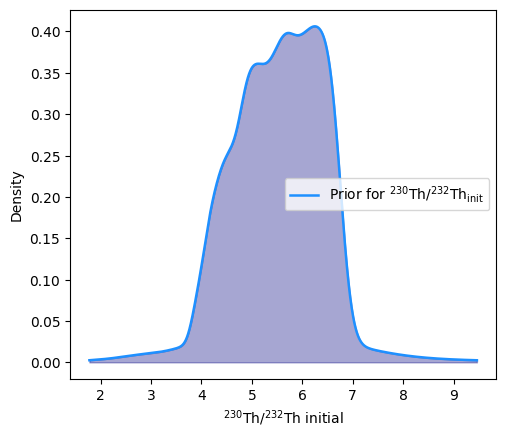

In [5]:
test.Plot_Priors()

In [6]:
test.Run_MCMC()

Generating new starting θ’s


In [8]:
import numpy as np 
from scipy.stats import gaussian_kde, norm
import matplotlib.pyplot as plt
Faraji_Th = np.array([8.05, 6.00, 5.98, 6.63, 7.74, 6.55, 6.01, 6.21, 6.87, 4.88])
Faraji_Th_err = np.array([0.24, 0.25, 0.27, 0.25, 0.18, 0.21, 0.50, 0.46, 0.27, 0.97])

In [9]:
boots = []
for i in range(len(Faraji_Th)): 
    y = np.random.normal(Faraji_Th[i], Faraji_Th_err[i], 10000)
    boots.append(y)

In [10]:
from scipy.stats import gaussian_kde, norm
kde_faraji = gaussian_kde(np.array(boots).flatten())

Text(0, 0.5, 'Density')

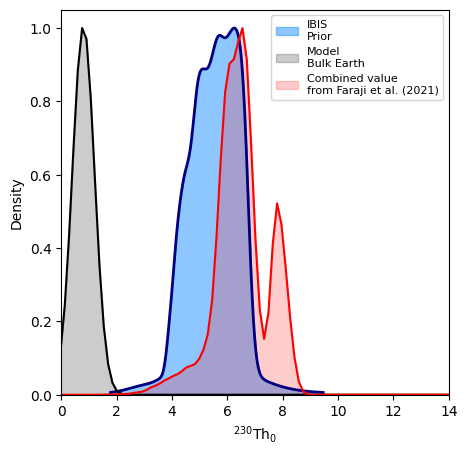

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (5,5))
ax.plot(test.thor_kde.x, test.thor_kde.y/test.thor_kde.y.max(), color = 'navy', lw = 2)
ax.fill_between(test.thor_kde.x, test.thor_kde.y/test.thor_kde.y.max(), color = 'dodgerblue', alpha = 0.5, 
                   label = 'IBIS\nPrior')

x = np.linspace(-.5, 15, 100)
ax.plot(x, norm(loc = 0.8, scale = 0.4).pdf(x)/ norm(loc = 0.8, scale = 0.4).pdf(x).max(), 
       color = 'k')
ax.fill_between(x, norm(loc = 0.8, scale = 0.4).pdf(x)/ norm(loc = 0.8, scale = 0.4).pdf(x).max(), 
       color = 'k', alpha = 0.2, label = 'Model\nBulk Earth')


ax.plot(x, kde_faraji(x)/kde_faraji(x).max(),
       color = 'r')
ax.fill_between(x, kde_faraji(x)/kde_faraji(x).max(),
       color = 'r', alpha = 0.2, label = 'Combined value\nfrom Faraji et al. (2021)')


ax.legend(fontsize = 8)
ax.set_ylim(bottom = 0.0)
ax.set_xlim(0, 14)
ax.set_xlabel('$^{230}$Th$_{0}$')
ax.set_ylabel('Density')

In [17]:
thor_model, thor_model_err = test.Model_Initial_Thorium()
depths = test.df_reduced['Depths'].values



Model Validation
-----
Faraji et al. (2021) back-calculate the (
Th/
Th)
 required to align both the U-Th ages and lamina counting chronology. We compare these to the IBIS-derived estimates as a test of model validation. We show this in the plot below.

Results
----
All IBIS-derived results are statistically indistinguishable from the back-calcualted values reported by Faraji et al. (2021). In the majority of cases the IBIS-derived uncertainty is greater than the back-calculated value. However, the is a remarkable increase in accuracy of the U-Th ages using IBIS. We conclude that sacrificing precision for accuracy is the "best" way to analyse complex data of this type.

Text(0.5, 0, '$^{230}$Th$^{232}$Th$_{A0}$ (units)')

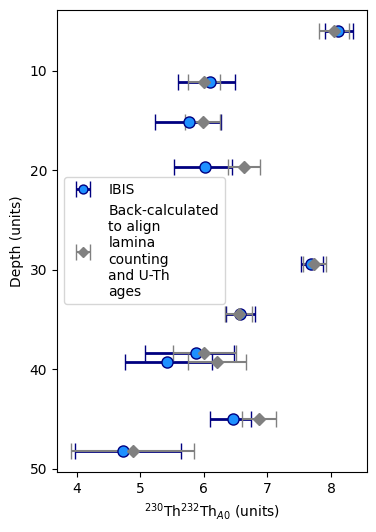

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (4, 6))
ax.errorbar(y = depths, x = thor_model, xerr = thor_model_err, 
            
            fmt = 'o', capsize = 6, 
           label = 'IBIS', markerfacecolor = 'dodgerblue', 
           markeredgecolor = 'navy', ecolor = 'navy', 
           markersize = 8, lw = 2)

ax.errorbar(y = depths, x = Faraji_Th, xerr = Faraji_Th_err, 
            fmt = 'D', capsize = 6, 
           label = 'Back-calculated\nto align\nlamina\ncounting\nand U-Th\nages', 
           color = 'grey')

ax.invert_yaxis()
ax.legend(markerscale = 0.8)
ax.set_ylabel('Depth (units)')
ax.set_xlabel('$^{230}$Th$^{232}$Th$_{A0}$ (units)')